# About: Simple Hivemall query for Test

---

Hivemallの動作確認として、 [a9a binary classification](https://github.com/myui/hivemall/wiki#a9a-binary-classification) で示されたLogistic Regressionの動作確認をしてみる。

## *Operation Note*

*This is a cell for your own recording.  ここに経緯を記述*

# Notebookと環境のBinding

Inventory中のgroup名でBind対象を指示する。

In [1]:
target_group = 'hadoop_all_testcluster'

# Datasetの準備

https://github.com/myui/hivemall/wiki/a9a-binary-dataset に従い、DatasetをHDFSにコピーし、tableを作成する。

http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#a9a から、以下のファイルをダウンロードする。

In [2]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmpmkdyRn'

In [3]:
%env WORK_DIR={work_dir}

env: WORK_DIR=/tmp/tmpmkdyRn


In [4]:
%%bash
cd ${WORK_DIR}
curl -O http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a
curl -O http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a.t

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2275k  100 2275k    0     0  5954k      0 --:--:-- --:--:-- --:--:-- 5971k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1137k  100 1137k    0     0  4090k      0 --:--:-- --:--:-- --:--:-- 4105k


整形をおこなう。

In [5]:
%%bash
cd ${WORK_DIR}
curl -O https://raw.githubusercontent.com/myui/hivemall/master/resources/misc/conv.awk

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   167  100   167    0     0    536      0 --:--:-- --:--:-- --:--:--   538


In [6]:
%%bash
cd ${WORK_DIR}
awk -f conv.awk a9a | sed -e "s/+1/1/" | sed -e "s/-1/0/" > a9a.train
awk -f conv.awk a9a.t | sed -e "s/+1/1/" | sed -e "s/-1/0/" > a9a.test

整形したデータをHDFSにアップロードする。

まずこのNotebook環境の一時ディレクトリから `hadoop_client` マシンにコピーしてから、 `hadoop fs` コマンドでコピーする。

In [7]:
hdfs_dataset_dir = '/dataset/a9a'
hadoop_client_dir = '~/a9a'

このNotebook環境から `hadoop_client` マシンへのコピー・・・

In [8]:
!ansible -m copy -a 'src={work_dir}/a9a.train dest={hadoop_client_dir}/' hadoop_client -l {target_group}
!ansible -m copy -a 'src={work_dir}/a9a.test dest={hadoop_client_dir}/' hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": false, 
    "checksum": "0105fad83d99e5c97c199572ace5cb71fe477313", 
    "dest": "/home/ansible/a9a/a9a.train", 
    "gid": 500, 
    "group": "ansible", 
    "mode": "0664", 
    "owner": "ansible", 
    "path": "/home/ansible/a9a/a9a.train", 
    "size": 2449013, 
    "state": "file", 
    "uid": 500
}
XXX.XXX.XXX.72 | SUCCESS => {
    "changed": false, 
    "checksum": "21117ece0f1f42a6b0a551a5cdb45535025f2361", 
    "dest": "/home/ansible/a9a/a9a.test", 
    "gid": 500, 
    "group": "ansible", 
    "mode": "0664", 
    "owner": "ansible", 
    "path": "/home/ansible/a9a/a9a.test", 
    "size": 1218646, 
    "state": "file", 
    "uid": 500
}


`hadoop fs` コマンドを実行する。

以下、すでに `/dataset/a9a` が存在している場合はコメントを外して使用する。

In [11]:
#!ansible -m shell -a "chdir={hadoop_client_dir} \
#                      hadoop fs -rm -r {hdfs_dataset_dir}" hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>
Deleted /dataset/a9a16/08/26 07:28:52 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.



In [12]:
!ansible -m shell -a "chdir={hadoop_client_dir} \
                      hadoop fs -mkdir -p {hdfs_dataset_dir}/train && \
                      hadoop fs -mkdir -p {hdfs_dataset_dir}/test && \
                      hadoop fs -copyFromLocal a9a.train {hdfs_dataset_dir}/train && \
                      hadoop fs -copyFromLocal a9a.test {hdfs_dataset_dir}/test" hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>




念のため、HDFSにファイルがアップロードされていることを確認しておく。

以下の `dataset_dir/train`, `dataset_dir/test` それぞれのディレクトリに、 `a9a.train`, `a9a.test` が作成されていればOK。

In [13]:
!ansible -a 'hadoop fs -ls {hdfs_dataset_dir}/train' hadoop_client -l {target_group}
!ansible -a 'hadoop fs -ls {hdfs_dataset_dir}/test' hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>
Found 1 items
-rw-r--r--   3 ansible supergroup    2449013 2016-08-26 07:29 /dataset/a9a/train/a9a.train

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>
Found 1 items
-rw-r--r--   3 ansible supergroup    1218646 2016-08-26 07:29 /dataset/a9a/test/a9a.test



データベースおよびテーブルを作成する。まずはHiveのクエリを作成する。

## データベースのdrop

必要に応じてコメントを外して使用する。

In [22]:
#%%writefile {work_dir}/drop.query
#use a9a;
#drop table a9atrain;
#drop table a9atest;
#drop table a9a_model1;
#drop view a9a_predict1;
#drop view a9a_submit1;
#drop view a9atest_exploded;
#drop database a9a;

In [23]:
#!ansible -m copy -a 'src={work_dir}/drop.query dest={hadoop_client_dir}/' hadoop_client -l {target_group}
#!ansible -a 'hive -f {hadoop_client_dir}/drop.query' hadoop_client -l {target_group}

## テーブルの作成

テーブルを作成する。まずはHiveクエリの作成。

In [24]:
import os
with open(os.path.join(work_dir, 'hive.query'), 'w') as f:
    f.write('''
create database a9a;
use a9a;

create external table a9atrain (
  rowid int,
  label float,
  features ARRAY<STRING>
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\\t' COLLECTION ITEMS TERMINATED BY "," STORED AS TEXTFILE LOCATION '{hdfs_dataset_dir}/train';

create external table a9atest (
  rowid int, 
  label float,
  features ARRAY<STRING>
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\\t' COLLECTION ITEMS TERMINATED BY "," STORED AS TEXTFILE LOCATION '{hdfs_dataset_dir}/test';
'''.format(hdfs_dataset_dir=hdfs_dataset_dir))

!cat {work_dir}/hive.query


create database a9a;
use a9a;

create external table a9atrain (
  rowid int,
  label float,
  features ARRAY<STRING>
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t' COLLECTION ITEMS TERMINATED BY "," STORED AS TEXTFILE LOCATION '/dataset/a9a/train';

create external table a9atest (
  rowid int, 
  label float,
  features ARRAY<STRING>
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t' COLLECTION ITEMS TERMINATED BY "," STORED AS TEXTFILE LOCATION '/dataset/a9a/test';


クエリを実行する。

hiveコマンド実行時に `WARNING: Use "yarn jar" to launch YARN applications.` なる警告が表示されるが、これは無視する。
([Warning "yarn jar" instead of "hadoop jar" in hadoop 2.7.0](https://issues.apache.org/jira/browse/HIVE-10100))

In [26]:
!ansible -m copy -a 'src={work_dir}/hive.query dest={hadoop_client_dir}/' hadoop_client -l {target_group}
!ansible -a 'hive -f {hadoop_client_dir}/hive.query' hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": true, 
    "checksum": "b27b2b59425d8e81ae2f83486c31b61d9b293fe4", 
    "dest": "/home/ansible/a9a/hive.query", 
    "gid": 500, 
    "group": "ansible", 
    "md5sum": "9d398e1bdd9a6e994be68d1b796e23f1", 
    "mode": "0664", 
    "owner": "ansible", 
    "size": 472, 
    "src": "/home/ansible/.ansible/tmp/ansible-tmp-1472164627.77-216599425494495/source", 
    "state": "file", 
    "uid": 500
}
XXX.XXX.XXX.72 | SUCCESS | rc=0 >>

Logging initialized using configuration in file:/etc/hive/conf/hive-log4j.properties
OK
Time taken: 0.278 seconds
OK
Time taken: 0.012 seconds
OK
Time taken: 0.412 seconds
OK
Time taken: 0.056 seconds



これでDatasetの準備OK。データ数の確認をしておく。

In [29]:
!ansible -m shell -a 'hive -e "use a9a; select count(1) from a9atrain; select count(1) from a9atest;" \
                      > {hadoop_client_dir}/count_rows.result' hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>

Logging initialized using configuration in file:/etc/hive/conf/hive-log4j.properties
OK
Time taken: 0.056 seconds
Query ID = ansible_20160826073958_ae1d093b-ce00-41b5-b42f-7d99aa02980f
Total jobs = 1
Launching Job 1 out of 1


Status: Running (Executing on YARN cluster with App id application_1471559811619_0065)

Map 1: -/-	Reducer 2: 0/1	
Map 1: 0/1	Reducer 2: 0/1	
Map 1: 0/1	Reducer 2: 0/1	
Map 1: 0(+1)/1	Reducer 2: 0/1	
Map 1: 1/1	Reducer 2: 0/1	
Map 1: 1/1	Reducer 2: 0(+1)/1	
Map 1: 1/1	Reducer 2: 1/1	
OK
Time taken: 11.838 seconds, Fetched: 1 row(s)
Query ID = ansible_20160826074010_bd0ecf02-a14a-4aa7-9e2e-c2092ca9ff27
Total jobs = 1
Launching Job 1 out of 1


Status: Running (Executing on YARN cluster with App id application_1471559811619_0065)

Map 1: 0(+1)/1	Reducer 2: 0/1	
Map 1: 1/1	Reducer 2: 0/1	
Map 1: 1/1	Reducer 2: 0(+1)/1	
Map 1: 1/1	Reducer 2: 1/1	
OK
Time taken: 1.539 seconds, Fetched: 1 row(s)



In [30]:
!ansible -a 'cat {hadoop_client_dir}/count_rows.result' hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>
32561
16281



出力結果に格納される2つの数値のうち、1つめが `a2atrain` の行数、2つめが `a2atest` の行数となる。

In [31]:
a9atrain_count = 32561
a9atest_count = 16281

# training

In [32]:
%%writefile {work_dir}/hive.query
use a9a;

create table a9a_model1 
as
select 
 cast(feature as int) as feature,
 avg(weight) as weight
from 
 (select 
     logress(addBias(features),label) as (feature,weight)
  from 
     a9atrain
 ) t 
group by feature;

Overwriting /tmp/tmpmkdyRn/hive.query


In [33]:
!ansible -m copy -a 'src={work_dir}/hive.query dest={hadoop_client_dir}/' hadoop_client -l {target_group}
!ansible -a 'hive -f {hadoop_client_dir}/hive.query' hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": true, 
    "checksum": "315c607f32e7ff6e0f4f96dfab918a6d2d2204c7", 
    "dest": "/home/ansible/a9a/hive.query", 
    "gid": 500, 
    "group": "ansible", 
    "md5sum": "3d3a53c1a199e264e53223ee4a529354", 
    "mode": "0664", 
    "owner": "ansible", 
    "size": 228, 
    "src": "/home/ansible/.ansible/tmp/ansible-tmp-1472164878.24-14894325444976/source", 
    "state": "file", 
    "uid": 500
}
XXX.XXX.XXX.72 | SUCCESS | rc=0 >>

Logging initialized using configuration in file:/etc/hive/conf/hive-log4j.properties
OK
Time taken: 0.072 seconds
Query ID = ansible_20160826074146_d5e23fda-5749-41de-b6dc-e1f14aef575c
Total jobs = 1
Launching Job 1 out of 1


Status: Running (Executing on YARN cluster with App id application_1471559811619_0066)

Map 1: -/-	Reducer 2: 0/1	
Map 1: 0/1	Reducer 2: 0/1	
Map 1: 0/1	Reducer 2: 0/1	
Map 1: 0(+1)/1	Reducer 2: 0/1	
Map 1: 0(+1)/1	Reducer 2: 0/1	
Map 1: 1/1	Reducer 2: 0(+1)/1	
Map 1: 1/1	Reducer 2: 1/1	
Movi

# prediction

In [34]:
%%writefile {work_dir}/hive.query
use a9a;

create or replace view a9atest_exploded as
select 
  rowid,
  label,
  extract_feature(feature) as feature,
  extract_weight(feature) as value
from 
  a9atest LATERAL VIEW explode(addBias(features)) t AS feature;

create or replace view a9a_predict1 as
select
  t.rowid, 
  sigmoid(sum(m.weight * t.value)) as prob,
  CAST((case when sigmoid(sum(m.weight * t.value)) >= 0.5 then 1.0 else 0.0 end) as FLOAT) as label
from 
  a9atest_exploded t LEFT OUTER JOIN
  a9a_model1 m ON (t.feature = m.feature)
group by
  t.rowid;

Overwriting /tmp/tmpmkdyRn/hive.query


In [35]:
!ansible -m copy -a 'src={work_dir}/hive.query dest={hadoop_client_dir}/' hadoop_client -l {target_group}
!ansible -a 'hive -f {hadoop_client_dir}/hive.query' hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": true, 
    "checksum": "c8cb50ab53e4ee3e0db3daee48139ed888f58c45", 
    "dest": "/home/ansible/a9a/hive.query", 
    "gid": 500, 
    "group": "ansible", 
    "md5sum": "97b3bef77bda574b045f1af43c851aa1", 
    "mode": "0664", 
    "owner": "ansible", 
    "size": 537, 
    "src": "/home/ansible/.ansible/tmp/ansible-tmp-1472164924.24-47476934008382/source", 
    "state": "file", 
    "uid": 500
}
XXX.XXX.XXX.72 | SUCCESS | rc=0 >>

Logging initialized using configuration in file:/etc/hive/conf/hive-log4j.properties
OK
Time taken: 0.028 seconds
OK
Time taken: 1.285 seconds
OK
Time taken: 0.305 seconds



# evaluation

In [36]:
with open(os.path.join(work_dir, 'hive.query'), 'w') as f:
    f.write('''use a9a;

create or replace view a9a_submit1 as
select 
  t.label as actual, 
  pd.label as predicted, 
  pd.prob as probability
from 
  a9atest t JOIN a9a_predict1 pd 
    on (t.rowid = pd.rowid);

select count(1) / {num_test_instances} from a9a_submit1 
where actual == predicted;'''.format(num_test_instances=a9atest_count))
    
!cat {work_dir}/hive.query

use a9a;

create or replace view a9a_submit1 as
select 
  t.label as actual, 
  pd.label as predicted, 
  pd.prob as probability
from 
  a9atest t JOIN a9a_predict1 pd 
    on (t.rowid = pd.rowid);

select count(1) / 16281 from a9a_submit1 
where actual == predicted;

In [37]:
!ansible -m copy -a 'src={work_dir}/hive.query dest={hadoop_client_dir}/' hadoop_client -l {target_group}
!ansible -a 'hive -f {hadoop_client_dir}/hive.query' hadoop_client -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": true, 
    "checksum": "b9205dbd578f59c6f89d4fe5c6557bc6735f3417", 
    "dest": "/home/ansible/a9a/hive.query", 
    "gid": 500, 
    "group": "ansible", 
    "md5sum": "2df1d172658f1321e825cced32b7b45a", 
    "mode": "0664", 
    "owner": "ansible", 
    "size": 267, 
    "src": "/home/ansible/.ansible/tmp/ansible-tmp-1472164957.98-160344252851358/source", 
    "state": "file", 
    "uid": 500
}
XXX.XXX.XXX.72 | SUCCESS | rc=0 >>

Logging initialized using configuration in file:/etc/hive/conf/hive-log4j.properties
OK
Time taken: 0.05 seconds
OK
Time taken: 1.491 seconds
Query ID = ansible_20160826074309_1848469a-dcd0-41ee-af32-8f0e51517965
Total jobs = 1
Launching Job 1 out of 1


Status: Running (Executing on YARN cluster with App id application_1471559811619_0068)

Map 1: -/-	Map 4: -/-	Map 5: -/-	Reducer 2: 0/1	Reducer 3: 0/1	
Map 1: 0/1	Map 4: 0/1	Map 5: 0/1	Reducer 2: 0/1	Reducer 3: 0/1	
Map 1: 0/1	Map 4: 0/1	Map 5: 0/1	Reducer 2: 0/1	

# 実行経過の確認

## ログの確認

ログは、 `yarn logs` コマンドにより確認することができる。この際、Application IDが必要。この情報はログから確認することができる。

> `Status: Running (Executing on YARN cluster with App id application_1471559811619_0068)`

In [38]:
yarn_application_id = 'application_1471559811619_0068'

## Swimlanesによる可視化

SwimlaneインストールNotebookによりTez-toolsをインストールしていれば、Swimlaneにより可視化することもできる。

In [39]:
%%writefile {work_dir}/swimlane.yml
- hosts: hadoop_swimlane
  tasks:
    - name: delete_swimlane_old_output
      become: yes
      file: path={{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/{{ yarn_application_id }}.svg state=absent
  
    - name: create_swimlane_analyze
      shell: bash yarn-swimlanes.sh {{ yarn_application_id }}
      args:
        chdir: "{{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/"
  
    - name: download_svg
      fetch: src={{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/{{ yarn_application_id }}.svg dest={{ local_svg_path }} flat=yes


Writing /tmp/tmpmkdyRn/swimlane.yml


SVGは一時ディレクトリにダウンロードし、Notebookにレンダリングすることにする。

In [40]:
local_svg_path = os.path.join(work_dir, 'result.svg')

swimlaneのスクリプトを実行し、SVGファイルをダウンロードする。

In [41]:
extra_vars = ['-e yarn_application_id={}'.format(yarn_application_id), '-e local_svg_path={}'.format(local_svg_path)]
!ansible-playbook {' '.join(extra_vars)} {work_dir}/swimlane.yml -l {target_group}


PLAY [hadoop_swimlane] *********************************************************

TASK [setup] *******************************************************************
ok: [XXX.XXX.XXX.72]

TASK [delete_swimlane_old_output] **********************************************
ok: [XXX.XXX.XXX.72]

TASK [create_swimlane_analyze] *************************************************
changed: [XXX.XXX.XXX.72]

TASK [download_svg] ************************************************************
changed: [XXX.XXX.XXX.72]

PLAY RECAP *********************************************************************
XXX.XXX.XXX.72               : ok=4    changed=2    unreachable=0    failed=0   



ダウンロードしたSVGファイルをレンダリングする。

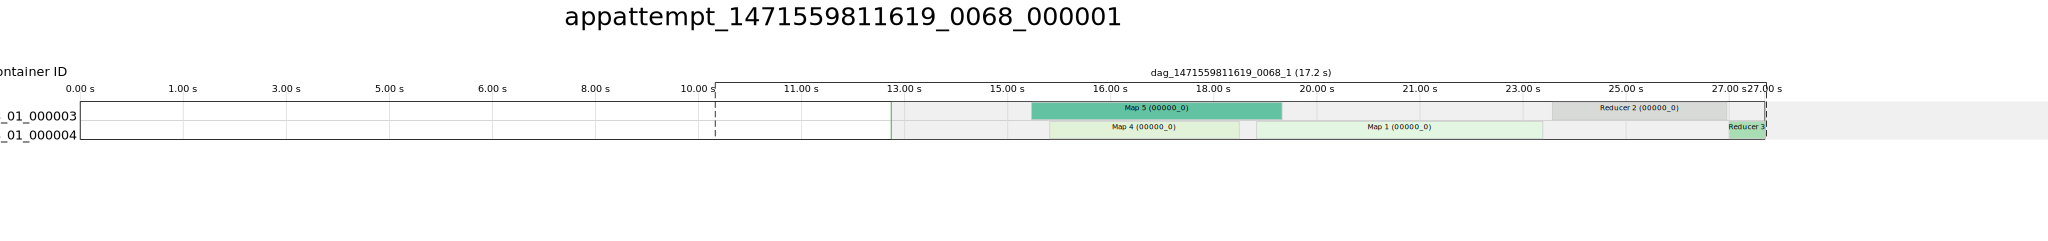

In [42]:
from IPython.display import SVG
SVG(filename=local_svg_path)

# 後始末

一時ディレクトリを削除する。

In [43]:
!rm -fr {work_dir}